# Solución para la predicción de la diabetes

## Modelo de refuerzo

### Opciones y paquetes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config IPCompleter.greedy=True  # Automcompletado rápido
%matplotlib inline
# Asegurarse de que matplotlib use el backend inline para mostrar gráficos en Jupyter
# Hace que los gráficos generados con matplotlib se muestren directamente dentro del notebook, justo debajo de la celda que los genera.



### Importación de datos

In [3]:
train_data = pd.read_csv("Teorico/1. Decision_Tree/data/processed/clean_train.csv")
test_data = pd.read_csv("Teorico/1. Decision_Tree/data/processed/clean_test.csv")

train_data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,84.0,0.0,0.0,0.0,0.3,21.0,0
1,9.0,112.0,82.0,0.0,28.2,1.3,50.0,1
2,1.0,139.0,46.0,83.0,28.7,0.7,22.0,0
3,0.0,161.0,50.0,0.0,21.9,0.3,65.0,0
4,6.0,134.0,80.0,370.0,46.2,0.2,46.0,1


### Modelo

#### Separar train y test

In [4]:
# Como ya importamos el df del proyecto de decision tree, 
# separado en train y test, no es necesario correr este codigo:

# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#### Separar predictoras y target

In [5]:
X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

#### Entrenar el modelo

In [ ]:
from xgboost import XGBClassifier


# Verificar la versión de XGBoost instalada (Recomendado: >= 1.3)

try:    
    from xgboost import __version__ as xgb_version
    print(f"XGBoost version: {xgb_version}")
except ImportError:             
    print("XGBoost no está instalado. Por favor, instale XGBoost para continuar.")
    xgb_version = None

# Verificar si la versión de XGBoost es compatible
if xgb_version is not None:
    major_version = int(xgb_version.split('.')[0])
    minor_version = int(xgb_version.split('.')[1]) if len(xgb_version.split('.')) > 1 else 0
    
    if major_version < 1 or (major_version == 1 and minor_version < 3):
        print("La versión de XGBoost es inferior a la recomendada (>= 1.3). Algunas funcionalidades pueden no estar disponibles.")
    else:
        print("La versión de XGBoost es compatible.")   

XGBoost version: 3.0.0
La versión de XGBoost es compatible.


In [39]:
# ◯ Instanciar el clasificador XGBoost y configurar los parámetros
        # ✓ use_label_encoder=False: Evita la advertencia de uso del codificador de etiquetas obsoleto en versiones recientes de XGBoost.
        # ✓ eval_metric='error': Usamos tasa de error como métrica donde 'error' = 1 - accuracy
        # ✓ early_stopping_rounds=5: Detiene el entrenamiento si no hay mejora en la métrica de evaluación durante 5 rondas consecutivas.
        # ✓ random_state=42: Para reproducibilidad

xgb = XGBClassifier(use_label_encoder=False, eval_metric='error', early_stopping_rounds=5, random_state=42) 

# Entrenar
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-error:0.26623
[1]	validation_0-error:0.25325
[2]	validation_0-error:0.25974
[3]	validation_0-error:0.25325
[4]	validation_0-error:0.27273
[5]	validation_0-error:0.27922
[6]	validation_0-error:0.29870


/home/vscode/.local/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:55:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

#### Predecir sobre test

In [38]:
# Obtener las probabilidades de la clase positiva (1) para la curva ROC
pred = xgb.predict_proba(X_test)[:, 1] 
# Mostrar las primeras 10 predicciones de probabilidad
pred[:10]

array([0.45590618, 0.41050512, 0.19143906, 0.24622813, 0.2450111 ,
       0.45590618, 0.19143906, 0.4562654 , 0.5943202 , 0.5795205 ],
      dtype=float32)

#### Evaluar sobre test

Accuracy: 0.7468


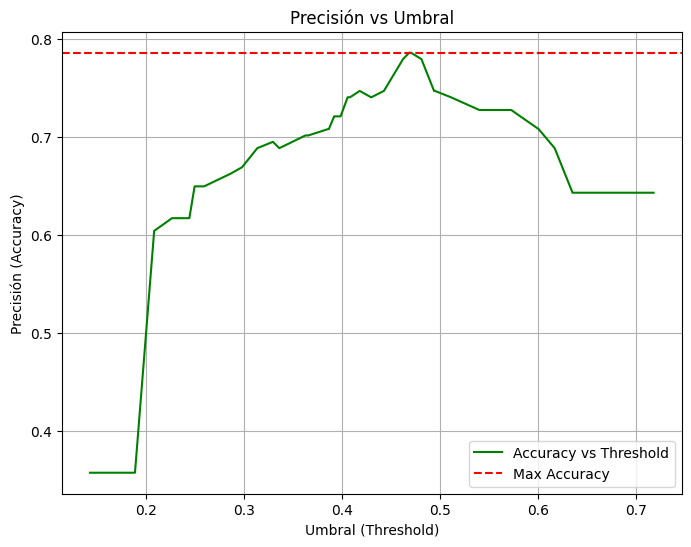

max accuracy:  0.7857142857142857
optimal threshold:  0.47035256


In [43]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, xgb.predict(X_test))

# Imprimir la precisión (accuracy) del modelo en el conjunto de prueba
print(f"Accuracy: {accuracy_score(y_test, xgb.predict(X_test)):.4f}")

# Visualizar la curva Accuracy vs Threshold
plt.figure(figsize=(8, 6))                  
accuracy = []
for threshold in thresholds:
    pred_binary = (pred >= threshold).astype(int)
    acc = accuracy_score(y_test, pred_binary)
    accuracy.append(acc)
plt.plot(thresholds, accuracy, label='Accuracy vs Threshold', color='green')
plt.xlabel('Umbral (Threshold)')
plt.ylabel('Precisión (Accuracy)')
plt.title('Precisión vs Umbral')        
plt.axhline(y=max(accuracy), color='r', linestyle='--', label='Max Accuracy')
plt.legend()    
plt.grid()
plt.show()

print("max accuracy: ", max(accuracy)) # Imprime la máxima precisión
print("optimal threshold: ", thresholds[np.argmax(accuracy)]) # Imprime el umbral óptimo

#### Revisión de los parámetros de entrenamiento

In [44]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': 5,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

#### Análisis de la importancia de las variables

XGBoost calcula la importancia de las variables como la ganancia media en todos los nodos en los que se ha usado la variable.

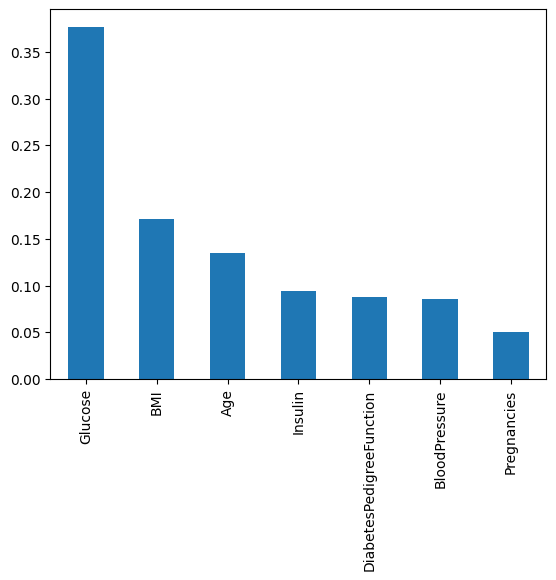

In [45]:
pd.Series(xgb.feature_importances_,index = X_test.columns).sort_values(ascending = False).plot(kind = 'bar');

O un dataframe

In [46]:
importancia = pd.DataFrame({'variable': X_test.columns, 'importancia': xgb.feature_importances_})
importancia.sort_values(by = 'importancia', ascending = False)

,variable,importancia
1,Glucose,0.4
4,BMI,0.2
6,Age,0.1
3,Insulin,0.1
5,DiabetesPedigreeFunction,0.1
2,BloodPressure,0.1
0,Pregnancies,0.1


In [47]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators = 800, max_depth=5, learning_rate = 0.001, random_state = 42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=800,
              n_jobs=None, num_parallel_tree=None, ...)

In [48]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [49]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.7792207792207793

Este algoritmo de refuerzo es mejor que el árbol de decisión optimizado.

In [ ]:
from pickle import dump

dump(model, open("models/boosting_classifier_nestimators-20_learnrate-0.001_42.sav", "wb"))